<a href="https://colab.research.google.com/github/pavankumarbalijepalli/pr-phi2-vs-defog/blob/main/fine_tune_phi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration

In [ ]:
!pip install datasets

In [ ]:
# Data Exploration Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from datasets import load_dataset

dataset = load_dataset("b-mc2/sql-create-context")
data_df = dataset['train'].to_pandas()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data_df.head()

,answer,context,question
0,SELECT COUNT(*) FROM head WHERE age > 56,CREATE TABLE head (age INTEGER),How many heads of the departments are older th...
1,"SELECT name, born_state, age FROM head ORDER B...","CREATE TABLE head (name VARCHAR, born_state VA...","List the name, born state and age of the heads..."
2,"SELECT creation, name, budget_in_billions FROM...","CREATE TABLE department (creation VARCHAR, nam...","List the creation year, name and budget of eac..."
3,"SELECT MAX(budget_in_billions), MIN(budget_in_...",CREATE TABLE department (budget_in_billions IN...,What are the maximum and minimum budget of the...
4,SELECT AVG(num_employees) FROM department WHER...,CREATE TABLE department (num_employees INTEGER...,What is the average number of employees of the...


<Axes: xlabel='count', ylabel='difficulty'>

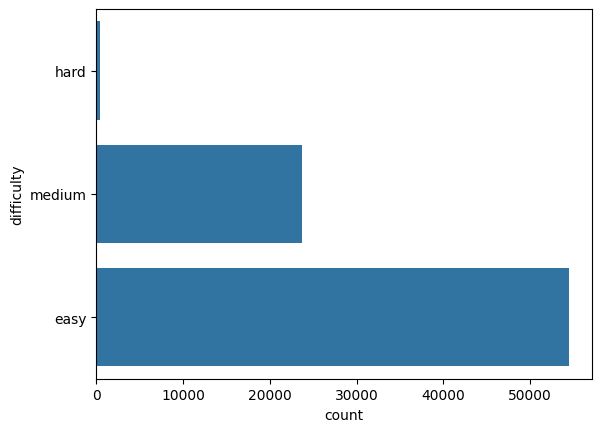

In [ ]:
# Finding the complexity of the datapoint
data_df['table_count'] = data_df['context'].apply(lambda x: x.split(' ').count('CREATE'))
data_df['sub_query_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('SELECT'))
data_df['joins_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('JOIN'))
data_df['where_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('WHERE'))
data_df['group_by_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('GROUP BY'))
data_df['columns_count'] = data_df['context'].apply(lambda x: list(x).count(',')) + data_df['table_count']

# Finding the complexity based on the above values
data_df['complexity'] = data_df['table_count'] + data_df['sub_query_count'] + data_df['joins_count'] + data_df['where_count'] + data_df['group_by_count'] + data_df['columns_count']
data_df = data_df.sort_values(by='complexity', ascending=False)

# Marking Difficulty based on threshold
data_df['difficulty'] = data_df['complexity'].apply(lambda x: 'easy' if x < 6 else 'medium' if x < 13 else 'hard')
sns.countplot(data_df['difficulty'])

In [ ]:
# Split data into train and test set also maintaining the ratio in difficulty column
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['difficulty'])

In [ ]:
# Create hugging face dataset from train_df and test_df
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[['context', 'answer', 'question', 'difficulty']], preserve_index=False)
test_dataset = Dataset.from_pandas(test_df[['context', 'answer', 'question', 'difficulty']], preserve_index=False)

In [ ]:
train_dataset, test_dataset

(Dataset({
     features: ['context', 'answer', 'question', 'difficulty'],
     num_rows: 70719
 }),
 Dataset({
     features: ['context', 'answer', 'question', 'difficulty'],
     num_rows: 7858
 }))

## Fine-tuning

In [ ]:
!pip install -q -U torch=='2.0.0'
!pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' trl=='0.7.4'
!pip install -q -U transformers einops

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [ ]:
## Convert Datasets to Dataframe
train_df = train_dataset.to_pandas()
test_df = test_dataset.to_pandas()

In [ ]:
## Retreive columns from the dataframes and modify functions accordingly

def generate_prompt(data_point):
    return f"""For the below database schema, write SQL query for,
    Question: {question}
    \nSchema: {context}
    \nThe SQL Query is {answer}""".strip()

def generate_test_prompt(data_point):
    return f"""For the below database schema, write SQL query for,
    Question: {question}
    \nSchema: {context}
    \nThe SQL Query is""".strip()

In [ ]:
train_data = Dataset.from_pandas(train_df)
eval_data = Dataset.from_pandas(test_df)

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), columns=["text"])

In [ ]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name,
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 3,
                        temperature = 0.0,
                       )
        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        answer = result[0]['generated_text'].split("The correct option is")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

In [ ]:
y_pred = predict(X_test, model, tokenizer)

In [ ]:
import re

def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

In [ ]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["Wqkv", "out_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="epoch"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=512,
)

In [ ]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model")

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

In [ ]:
y_pred = predict(X_test, model, tokenizer)

In [ ]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)